Task statement:

Multi-class классификация.
Рекуррентные и свёрточные нейрононные сети и embeddings для работы с текстом.

Датасет - Руcскоязычные отзывы с оценками.

Метрика - f1-score, weighted.

Задачи:

- Обучить линейную модель на TF-IDF представлении для предсказания оценки пользователя по его отзыву. Посмотреть на важность для каждой оценки.
- Обучить рекуррентную нейронную сеть для предсказания оценки пользователя по его отзыву. Использовать случайную инициализация весов.
- Обучить «fasttext» модель на n-граммах используя случайную инициализацию эмбедингов. 
- Обучить сharacter based модель (вместо слов мы подаём предложение посимвольно). 
    Заимплементить самому, либо нагуглить готовые имплементации.
- Опционально (for honor): Обучить модель из примера имплементации ниже, но с использованием уже предобученного word2vec для русского языка. в качестве инициализации эмбединга.


In [1]:
#update libs in colab
!pip install --upgrade pandas
!pip install --upgrade numpy
!pip install --upgrade scikit-learn
!pip install --upgrade seaborn
!pip install --upgrade tensorflow
#!pip install --upgrade pymystem3
!pip install --upgrade requests
!pip install --upgrade gensim
!pip install --upgrade imblearn
!pip install --upgrade wget
!pip install --upgrade ufal.udpipe

Requirement already up-to-date: pandas in c:\anaconda\lib\site-packages (0.24.1)
  Found existing installation: numpy 1.13.3
    Uninstalling numpy-1.13.3:
      Successfully uninstalled numpy-1.13.3


Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\chief\\AppData\\Local\\Temp\\pip-uninstall-ogib5rju\\anaconda\\lib\\site-packages\\numpy\\core\\libopenblas_v0.2.20_mingwpy.dll'
Consider using the `--user` option or check the permissions.



Requirement already up-to-date: scikit-learn in c:\anaconda\lib\site-packages (0.20.3)
Requirement already up-to-date: seaborn in c:\anaconda\lib\site-packages (0.9.0)
Requirement already up-to-date: tensorflow in c:\anaconda\lib\site-packages (1.13.1)
Requirement already up-to-date: requests in c:\anaconda\lib\site-packages (2.21.0)
Requirement already up-to-date: gensim in c:\anaconda\lib\site-packages (3.7.1)
Requirement already up-to-date: imblearn in c:\anaconda\lib\site-packages (0.0)


Requirement already up-to-date: wget in c:\anaconda\lib\site-packages (3.2)
Requirement already up-to-date: ufal.udpipe in c:\anaconda\lib\site-packages (1.2.0.1)


In [2]:
# to load/save models
# Load the Drive helper and mount
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#common libs
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3)

import re
import string
import itertools
from tqdm import tqdm_notebook as tqdm
#from tqdm import tqdm
from time import time
from collections import Counter

import pickle
import os
import re
import sys
import wget

seed = 321

%matplotlib inline

In [4]:
#sklearn libs
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline,Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report,f1_score, make_scorer

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.utils import shuffle,compute_class_weight

from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler

#part 5 libs
import gensim
import requests
from pymystem3 import Mystem

In [5]:
import tensorflow as tf

import keras
import json
import operator
from keras.preprocessing import sequence
from keras.models import Sequential, model_from_json,load_model
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Bidirectional 
from keras.layers import GlobalAveragePooling1D,Flatten,BatchNormalization, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D 
from keras.metrics import binary_accuracy,categorical_accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras import backend as K 

from keras.utils import np_utils

from keras.layers.noise import GaussianNoise
from keras import regularizers
from keras import utils
from keras.layers import GRU

from imblearn.keras import balanced_batch_generator
from imblearn.under_sampling import NearMiss, TomekLinks,AllKNN,RandomUnderSampler # TRY TOMEK!

#convert words to sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.datasets import imdb

Using TensorFlow backend.


In [6]:
import nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('names')

from nltk.corpus import names
from nltk.corpus import stopwords
from nltk import ngrams

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer # one more stemmer? or lemmatisation
from nltk.stem import WordNetLemmatizer,LancasterStemmer

from ufal.udpipe import Model as udpipe_Model
from ufal.udpipe import Pipeline as udpipe_Pipeline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


In [7]:
# temp function to get rundom n samples from dataset
def next_batch(num, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = data[idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [8]:
data = np.random.rand(50,2)
labels = np.random.randint(5, size=50).reshape(-1,1)

dataFrame = pd.DataFrame(data, columns = ['a','b'])
labelsFrame = pd.DataFrame(labels, columns = ['expected'])



# i can use imblearn.keras batch generator, but do not know, if it used there shuffle/reshuffle
# temp function to get rundom n samples from dataset
def train_flow_genetator(x_data, y_data, batch_size):#, sampler): 
  
  x_data, y_data = shuffle(x_data, y_data) #shuffle data, for 'true' shuffle random_state=seed
  batch_n = x_data.shape[0] // batch_size
  i = 0 #counter for pass
  
  while True:
    x_batch = x_data[batch_size*i:batch_size*(i+1)]
    y_batch = y_data[batch_size*i:batch_size*(i+1)]
    
    #x_batch, y_batch = sampler.fit_resample(x_batch, y_batch)
    
    i+=1
    yield np.asarray(x_batch), np.asarray(y_batch)
    
    if (i >= batch_n):
      print ("reshuffle!")
      i = 0
      x_data, y_data = shuffle(x_data, y_data) #shuffle data
      
      
def test_flow_genetator(x_data, y_data, batch_size): #isTest is used for case if we need generator for validation, yet is not implemented
  # will be good to check shape and type of inputs
  
  x_data, y_data = shuffle(x_data, y_data) #shuffle data, for 'true' shuffle random_state=seed
  batch_n = x_data.shape[0] // batch_size
  i = 0 #counter for pass
  
  while True:
    x_batch = x_data[batch_size*i:batch_size*(i+1)]
    y_batch = y_data[batch_size*i:batch_size*(i+1)]
    i+=1
    yield np.asarray(x_batch), np.asarray(y_batch)
    
    if (i >= batch_n):
      print ("reshuffle!")
      i = 0
      x_data, y_data = shuffle(x_data, y_data) #shuffle data

In [9]:
'''x = next_batch_test(dataFrame,labelsFrame,3)
for i in range(50):
  print (next(x))''';

In [10]:
'''#class weight sample
classes = np.unique(labelsFrame)

class_weight = compute_class_weight("balanced", classes, labelsFrame.iloc[:, 0])
class_weight_dict = dict(zip(classes, class_weight))

Counter(labelsFrame.iloc[:, 0])

print (class_weight_dict)''';

In [11]:
def classify_and_score(classifier, X_train, X_test, y_train, y_test):
    clf = classifier
    clf.fit(X_train, y_train)

    pred_train = clf.predict(X_train)
    #print ("Train score")
    f1_train = f1_score(y_train, pred_train, average='weighted')

    #print ("Test score")
    pred_test = clf.predict(X_test)
    f1_test = f1_score(y_test, pred_test, average='weighted')
    
    return f1_train, f1_test, clf

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Paired):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

#### EDA.

Считаем данные и выведем несколько образцов.

In [12]:
#x_data, y_data = pickle.load(open('drive/My Drive/data/reviews_dataset.pkl', 'rb'))
x_data, y_data = pickle.load(open('data/task_2/reviews_dataset.pkl', 'rb'))

In [13]:
len(x_data)

769251

In [14]:
len(y_data)

769251

In [15]:
x_data[0]

'Потрясающе красивая графика космоса! Уже за это игру можно полюбить. Так же в наличии интересный осмысленный сюжет и удобное управление.'

In [16]:
y_data[0]

5

In [17]:
x_data[33]

'Купил. Очень нравится. Пока нареканий нет никаких. Всегда очень нравились телефоны - слайдеры у Сименса, но у них не было BlueToth-а:(Наконец Simens сделал слайдер с с BlueTooth!'

In [18]:
y_data[33]

5

In [19]:
Counter(y_data)

Counter({5: 511671, 3: 59226, 1: 55327, 4: 110665, 2: 32362})

Похоже, положительные отзывы (4 и 5) превалируют над остальными классами.

Т.к. данных сравнительно много, попробуем использовать UnderSampling, для того, чтобы в обучающем наборе получить тексты всех классов.

#### Baseline.

Обучить линейную модель на TF-IDF представлении для предсказания оценки пользователя по его отзыву. 

Посмотреть на важность для каждой оценки.

Воспользуемся токенайзером для очистки и подготовки текстов.

Это поможет в будущем, при обучении алгоритмов + tokenizer от Keras не обладает функционалом отсечения стоп слов и лемматизации.

In [0]:
def remove_emails(text):
    text = re.sub(r'\S*@\S*\s?','',text)    
    return text


#version on raw text
def remove_punctuation2(text_punctuation,text):
    
    new_text = []
    new_text = re.sub('\n', ' ',text)
    new_text = re.sub('\t', '',new_text)
    new_text = re.sub('['+text_punctuation+']', ' ',new_text)
    new_text =  new_text.strip()
    
    return new_text

#version after word_tokenizer
def remove_punctuation(text_punctuation,text):
    
    new_text = []
    for word in text: 
        new_word =  re.sub('['+text_punctuation+']', ' ',word)
        new_word =  new_word.strip()
        new_text.append(new_word)
    
    return new_text


#ntlk word lemmatizer
def lemmatize_stemm_text(text):
    new_text_lemma = []
    new_text_stemm = []
    
    lemmatizer = WordNetLemmatizer()
    stemmer = LancasterStemmer()
    
    for word in text:
        lemma = lemmatizer.lemmatize(word, pos='n') # v default
        new_text_lemma.append(lemma)
        
        #stemm = stemmer.stem(word)
        #new_text_stemm.append(stemm)
        
    return new_text_lemma, new_text_stemm
        

StopWords = list(set(stopwords.words('russian')))
StopWords.remove('не')


def remove_stopwords(stop_words ,text):
    
    new_words = []
    for word in text:
        if word not in stop_words:
            new_words.append(word)

    return new_words

def remove_short_words(text, word_len):
    new_text = []
    for word in text:
        if len(word) >= word_len:
            new_text.append(word)
            
    return new_text


# getting source from string.punctuation
text_punctuation = '!"#$%&\'()*+,-.:;<=>?@[\\]_`{|}~/^'

def tokenize(text):
    min_length = 3
    
    # remove emails from text to prevent overfit
    text = remove_emails(text)
    
    # text to lowercase
    text =  text.lower()

    #remove punctuation
    text = remove_punctuation2(text_punctuation, text) 

    # tokenize text
    words = word_tokenize(text,language='english')

       
    # remove stopwords
    words = remove_stopwords(StopWords,words)
    
    #lemmatize words
    words,_ = lemmatize_stemm_text(words)
    
    #filter short words
    words = remove_short_words(words, 2) #default 3

    return words

In [0]:
%%time
test = tokenize(x_data[4])

In [0]:
test

Датасет достаточно объемный, поэтому в целях экономии времени:
- возьмем часть от него
- "токенизируем"
- поделим его еще раз на трейн-тест
- используем RandomUnderSampling

In [0]:
# tokenize
x_data_tokenized = []
for text in tqdm(x_data):
    tokenized_text = ' '.join(tokenize(text))
    x_data_tokenized.append(tokenized_text)

100%|██████████| 769251/769251 [06:48<00:00, 1881.48it/s]


In [0]:
#split to train/test
x_train, x_test, y_train, y_test = train_test_split(x_data_tokenized, y_data, random_state = seed, test_size=0.2, shuffle=True, stratify = y_data)

In [0]:
#dump to disk
path = "drive/My Drive/data/models/task3_data_preprocessed/"
with open(path + "tmp_tokenized.pickle", "wb") as f:
    pickle.dump((x_train,x_test,y_train,y_test), f)

In [0]:
#read from disk
path = "drive/My Drive/data/models/task3_data_preprocessed/"
with open(path + "tmp_tokenized.pickle", "rb") as f:
    x_train,x_test,y_train,y_test = pickle.load(f)

In [0]:
len(x_train)

615400

In [0]:
len(x_test)

153851

Undersample data, to make good set for learning.

In [0]:
n5 = Counter(y_train)[5] // 6 #the biggest class
n4 = Counter(y_train)[4] // 2 #second biggest class
n3 = Counter(y_train)[3] // 1
n2 = Counter(y_train)[2] // 1
n1 = Counter(y_train)[1] // 1

sum_n = np.sum([n5 , n4 , n3 , n2 , n1])
print (n5,n4,n3,n2,n1, "sum :" + str(sum_n)) # ratio we want

print(Counter(y_train), len (y_train)) # original data

29847 19366 20729 11327 19365 sum :100634
Counter({5: 179084, 4: 38732, 3: 20729, 1: 19365, 2: 11327}) 269237


In [0]:
x_train = np.reshape(x_train, (-1, 1)) #need numpy reshape for imblearn randomundersampler
#x_train = np.asarray(x_train)

In [0]:
rus = RandomUnderSampler(random_state=seed,ratio={1: n1, 2: n2, 3: n3, 4: n4,5: n5})
x_train, y_train = rus.fit_resample(x_train, y_train)

In [0]:
print(Counter(y_train))
x_train = np.array(x_train).tolist()

print (len(x_train))
print (len(y_train))

#reshuffle it
#because data is sorted after under sampling
x_train, y_train = shuffle(x_train, y_train, random_state=seed)

same idea for test, but here we just divide all targets by 4, to reduce array size.

In [0]:
n5 = Counter(y_test)[5] // 4
n4 = Counter(y_test)[4] // 4
n3 = Counter(y_test)[3] // 4
n2 = Counter(y_test)[2] // 4
n1 = Counter(y_test)[1] // 4

sum_n = np.sum([n5 , n4 , n3 , n2 , n1])
print (n5,n4,n3,n2,n1, "sum :" + str(sum_n))

print(Counter(y_test), len (y_test))

7675 1660 888 485 830 sum :11538
Counter({5: 30700, 4: 6640, 3: 3553, 1: 3320, 2: 1942}) 46155


In [0]:
x_test = np.reshape(x_test, (-1, 1))

In [0]:
rus = RandomUnderSampler(random_state=seed,ratio={1: n1, 2: n2, 3: n3, 4: n4,5: n5})
x_test, y_test = rus.fit_resample(x_test, y_test)

In [0]:
print(Counter(y_test))
x_test = np.array(x_test).tolist()

print (len(x_test))
print (len(y_test))

#reshuffle it
x_test, y_test = shuffle(x_test, y_test, random_state=seed)

Counter({5: 7675, 4: 1660, 3: 888, 1: 830, 2: 485})
11538
11538


In [0]:
#back to list of strings, for correct work of tokenizers
x_train = [item for sublist in x_train for item in sublist]
x_test = [item for sublist in x_test for item in sublist]

dump preprocessed train/test split.

In [0]:
path = "drive/My Drive/data/models/task3_data_preprocessed/"
with open(path + "tmp.pickle", "wb") as f:
    pickle.dump((x_train,x_test,y_train,y_test), f)

In [0]:
path = "drive/My Drive/data/models/task3_data_preprocessed/"
with open(path + "tmp.pickle", "rb") as f:
    x_train,x_test,y_train,y_test = pickle.load(f)

FileNotFoundError: ignored

In [0]:
#clean garbage    
del x_data_tokenized, x_data, y_data , path  

#### TFIDF + LogisticRegression.

In [0]:
vectorizer = TfidfVectorizer(stop_words=StopWords,
                             tokenizer=None, 
                             min_df=4, # ignore terms with freq less that т, lower majoring 4
                             max_df=0.8, # ignore terms with freq more that n, upper majoring 0.8
                             use_idf=True,  
                             sublinear_tf=True,
                             norm='l2',
                             lowercase = False                           
                            )

In [0]:
%%time
vectorised_train_documents = vectorizer.fit_transform(x_train)
vectorised_test_documents = vectorizer.transform(x_test)

CPU times: user 31.9 s, sys: 1.28 s, total: 33.2 s
Wall time: 33.2 s


In [0]:
vectorised_train_documents.shape

(615400, 154130)

In [0]:
vectorised_test_documents.shape

(153851, 154130)

In [0]:
log_reg = LogisticRegression(penalty='l2', tol=0.0001, C=1, 
                             class_weight='balanced', random_state=seed, 
                             max_iter=1000, solver = 'newton-cg',
                             multi_class='ovr', verbose=0, 
                             n_jobs=-1)

In [0]:
%%time
_,_, clf = classify_and_score(log_reg, vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)

CPU times: user 844 ms, sys: 361 ms, total: 1.21 s
Wall time: 3min 25s


              precision    recall  f1-score   support

           1       0.43      0.58      0.49     11066
           2       0.17      0.22      0.19      6472
           3       0.25      0.33      0.28     11845
           4       0.34      0.40      0.37     22133
           5       0.89      0.77      0.83    102335

   micro avg       0.64      0.64      0.64    153851
   macro avg       0.41      0.46      0.43    153851
weighted avg       0.70      0.64      0.67    153851

Confusion matrix, without normalization
None


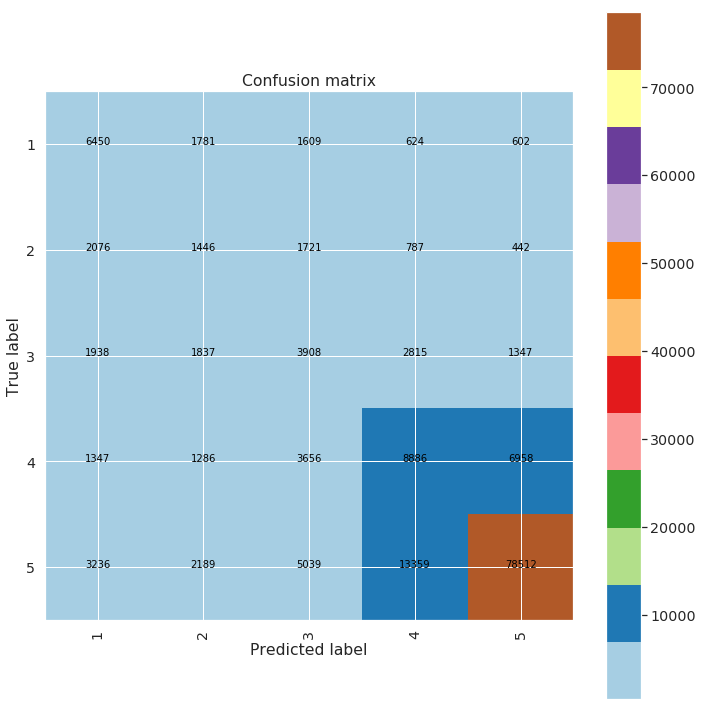

In [0]:
labels = clf.classes_
pred_test = clf.predict(vectorised_test_documents)
print(classification_report(y_test,pred_test,labels = labels))

cnf_matrix = confusion_matrix(y_test, pred_test)
print(plot_confusion_matrix(cnf_matrix, classes = labels))

Лучше всего классифицируется класс 5, т.к. его больше всего в тестовых данных.

Также стоит отметить классы 1 и 3, они содержат примерно одинаковое количество записей, при этом:
Класс 1 сравнительно неплохо классифицировался, при этом класс 3 классифицировался значительно хуже, и он похоже сливается с другими классами (2 и 4), судя по confusion matrix.

В целом алгоритм отработал средне, скорее всего если его обучить на всех данных и подобрать гиперпараметры, то результат изменится в лучшую сторону.

#### RNN.
Обучить рекуррентную нейронную сеть для предсказания оценки пользователя по его отзыву. Использовать случайную инициализация весов.

In [0]:
K.clear_session()

In [0]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)

# convert integers to dummy variables (i.e. one hot encoded)
y_train = np_utils.to_categorical(encoded_y_train)
y_test = np_utils.to_categorical(encoded_y_test)

In [0]:
# Set parameters
num_word = 45000
batch_size = 32
embedding_dims = 32
epochs = 5
maxlen = 40
task2_filepath = 'drive/My Drive/data/models/subtask2/'

In [0]:
#tokenize data 
%%time
tokenizer = Tokenizer(num_words=num_word)
tokenizer.fit_on_texts(x_train)

x_train_tokenized = tokenizer.texts_to_sequences(x_train)
x_test_tokenized  = tokenizer.texts_to_sequences(x_test)

CPU times: user 1min 25s, sys: 541 ms, total: 1min 26s
Wall time: 1min 26s


In [0]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
print (vocab_size)

503097


In [0]:
print('Average train sequence length: {}'.format(
        np.mean(list(map(len, x_train_tokenized)), dtype=int)))
print('Average test sequence length: {}'.format(
        np.mean(list(map(len, x_test_tokenized)), dtype=int)))

Average train sequence length: 22
Average test sequence length: 22


In [0]:
%%time
x_train_tokenized = pad_sequences(x_train_tokenized, padding='post', maxlen=maxlen)
x_test_tokenized = pad_sequences(x_test_tokenized, padding='post', maxlen=maxlen)

CPU times: user 4.29 s, sys: 94.9 ms, total: 4.38 s
Wall time: 4.38 s


In [0]:
vocab_size * embedding_dims # params of first layer, 128 is number of embeddings or num_word

16099104

In [0]:
#случайную инициализация весов
model = Sequential()
model.add(Embedding(input_dim = num_word, output_dim = embedding_dims,  #vocab_size
                    input_length=maxlen, activity_regularizer = regularizers.l2(0.001))
         )
model.add(GaussianNoise(0.01))
model.add(Bidirectional(GRU(units = 32, activation='sigmoid', recurrent_activation='hard_sigmoid', dropout = 0.2, recurrent_dropout=0.2),
                        weights = 'glorot_uniform'))# weights!
#model.add(Bidirectional(LSTM(units = 32, activation='relu', recurrent_dropout=0.4),weights = 'glorot_uniform'))# weights!
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax')) #softmax due to multiclass

# try using different optimizers and different optimizer configs
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

#print(model.summary())
utils.print_summary(model,line_length = 80)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
embedding_8 (Embedding)             (None, 40, 32)                  1440000     
________________________________________________________________________________
gaussian_noise_8 (GaussianNoise)    (None, 40, 32)                  0           
________________________________________________________________________________
bidirectional_8 (Bidirectional)     (None, 64)                      12480       
________________________________________________________________________________
dropout_8 (Dropout)                 (None, 64)                      0           
________________________________________________________________________________
dense_8 (Dense)                     (None, 5)                       325         
Total params: 1,452,805
Trainable params: 1,452,805
Non-trainable params: 0
_________________________________

In [0]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, 
                              verbose=1, min_delta=0.01,
                              mode='min',restore_best_weights=True)


checkpoint = ModelCheckpoint(task2_filepath + 'baseline_model_partial_gru.hdf5', monitor='val_loss', 
                             verbose=1, save_best_only=True, mode='min')

m_callbacks = [checkpoint, earlyStopping]

In [0]:
'''# no stratify
x_train_part,y_train_part = next_batch(40000, x_train_tokenized, y_train)
x_test_part,y_test_part = next_batch(10000, x_test_tokenized, y_test)

%%time
print('Train...')
history_model = model.fit(x_train_part, y_train_part,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          callbacks=m_callbacks,
          validation_data=[x_test_part, y_test_part])
          
history_model = model.fit(x_train_tokenized, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          callbacks=m_callbacks,
          validation_data=[x_test_tokenized, y_test])

''';

In [0]:
steps_per_epoch_train = x_train_tokenized.shape[0] // batch_size
steps_per_epoch_test = x_test_tokenized.shape[0] // batch_size
print (steps_per_epoch_train)

19231


In [0]:
def ratio_multiplier(y):
  multiplier = {0: 1, 1: 1, 2: 1, 3: 0.6, 4: 0.25}
  target_stats = Counter(y)
  for key, value in target_stats.items():
    if key in multiplier:
      target_stats[key] = int(value * multiplier[key])
  return target_stats

In [0]:
%%time
'''training_generator, steps_per_epoch = balanced_batch_generator(
    x_train_tokenized, y_train, 
    sampler=AllKNN(sampling_strategy = ratio_multiplier,random_state = seed, n_jobs = -1,n_neighbors = 5), 
    batch_size=batch_size, random_state=seed)
''';

training_generator, steps_per_epoch = balanced_batch_generator(
    x_train_tokenized, y_train, 
    sampler=RandomUnderSampler(sampling_strategy = ratio_multiplier,random_state = seed), 
    batch_size=batch_size, random_state=seed)

CPU times: user 470 ms, sys: 67.4 ms, total: 537 ms
Wall time: 542 ms


In [0]:
print (steps_per_epoch)

8530


In [0]:
tg_backup = training_generator
a = next(tg_backup)
reverse_a = np.argmax(a[1], axis=1)
Counter(reverse_a)

Counter({0: 7, 1: 2, 2: 3, 3: 7, 4: 13})

In [0]:
from collections import OrderedDict
#multiplier = {0: 1, 1: 1, 2: 1, 3: 0.7,4: 0.4}
reverse_y_train = np.argmax(y_train, axis=1)
reverse_y_train = ratio_multiplier(reverse_y_train)

print (OrderedDict(sorted(reverse_y_train.items(), key=lambda t: t[0])))

OrderedDict([(0, 44261), (1, 25890), (2, 47381), (3, 53119), (4, 102334)])


In [0]:
%%time
print('Train...')
history_model = model.fit_generator(epochs=epochs, verbose = 1, callbacks = m_callbacks, shuffle = True,
                                    generator = training_generator, #train_flow_genetator(x_train_tokenized, y_train,batch_size), 
                                    steps_per_epoch = steps_per_epoch, #steps_per_epoch_train, 
                                    validation_data=test_flow_genetator(x_test_tokenized, y_test, batch_size),
                                    validation_steps=steps_per_epoch_test)

Train...
Epoch 1/5
8530/8530 [==============================] - 575s 67ms/step - loss: 1.2451 - acc: 0.5029 - val_loss: 0.9705 - val_acc: 0.6627

Epoch 00001: val_loss improved from inf to 0.97050, saving model to drive/My Drive/data/models/subtask2/baseline_model_partial_gru.hdf5
Epoch 2/5
8530/8530 [==============================] - 571s 67ms/step - loss: 1.1919 - acc: 0.5362 - val_loss: 0.9539 - val_acc: 0.6656

Epoch 00002: val_loss improved from 0.97050 to 0.95391, saving model to drive/My Drive/data/models/subtask2/baseline_model_partial_gru.hdf5
Epoch 3/5
8530/8530 [==============================] - 579s 68ms/step - loss: 1.1559 - acc: 0.5604 - val_loss: 0.9544 - val_acc: 0.6654

Epoch 00003: val_loss did not improve from 0.95391
Epoch 4/5
8530/8530 [==============================] - 606s 71ms/step - loss: 1.1346 - acc: 0.5737 - val_loss: 0.9648 - val_acc: 0.6644

Epoch 00004: val_loss did not improve from 0.95391
Epoch 5/5
8530/8530 [==============================] - 596s 70ms/

In [0]:
'''%%time
#continue training
loaded_model = Sequential() #?
loaded_model = load_model(task2_filepath + 'baseline_model_partial.hdf5')

earlyStopping = EarlyStopping(monitor='val_loss', patience=3, 
                              verbose=1, min_delta=0.01,
                              mode='min',restore_best_weights=True)


checkpoint = ModelCheckpoint(task2_filepath + 'baseline_model_partial_cont.hdf5', monitor='val_loss', 
                             verbose=1, save_best_only=True, mode='min')

r_callbacks = [checkpoint, earlyStopping]


print('Train...')
history_model = loaded_model.fit_generator(epochs=4, verbose = 1, callbacks = r_callbacks, shuffle = True,
                                    generator = train_flow_genetator(x_train_tokenized, y_train,batch_size), 
                                    steps_per_epoch = steps_per_epoch_train, 
                                    validation_data=test_flow_genetator(x_test_tokenized, y_test, batch_size),
                                    validation_steps=steps_per_epoch_test)''';

In [0]:
'''# serialize model to JSON
model_json = model.to_json()
with open(path + "model" + ".json", "w") as json_file:
    json_file.write(model_json)''';

with open(task2_filepath + "history_partial_gru"+ ".json", 'w') as f:
    json.dump(history_model.history, f)
    
'''# serialize weights to HDF5
model.save_weights(path + "model" +  ".h5")
print("Saved model to disk")''';

In [0]:
#load history
json_file = open(task2_filepath + "history_partial_gru"+ ".json", 'r')
loaded_history_json = json.load(json_file)
json_file.close()

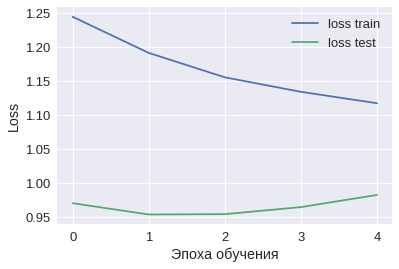

In [0]:
plt.plot(loaded_history_json['loss'], 
         label='loss train')
plt.plot(loaded_history_json['val_loss'], 
         label='loss test')
plt.xlabel('Эпоха обучения')
plt.ylabel('Loss')
plt.legend()
plt.show()

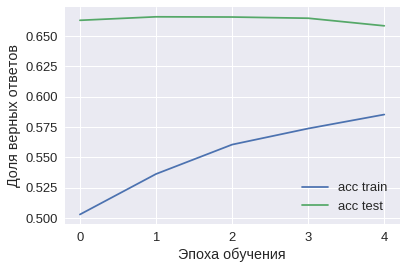

In [0]:
plt.plot(loaded_history_json['acc'], 
         label='acc train')
plt.plot(loaded_history_json['val_acc'], 
         label='acc test')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [0]:
'''

loaded_model = Sequential() #?
loaded_model = load_model(task2_filepath + 'baseline_model.hdf5')

''';

In [0]:
loaded_model = Sequential() #?
loaded_model = load_model(task2_filepath + 'baseline_model_partial_gru.hdf5')

In [0]:
y_predicted_scores = loaded_model.predict(x_test_tokenized)
y_predicted_scores[y_predicted_scores>=0.5] = 1
y_predicted_scores[y_predicted_scores<0.5] = 0

print('Classification report\n')
print(classification_report(y_test, y_predicted_scores))

Classification report

              precision    recall  f1-score   support

           0       0.60      0.37      0.46     11066
           1       0.00      0.00      0.00      6472
           2       1.00      0.00      0.00     11845
           3       0.53      0.04      0.08     22133
           4       0.89      0.72      0.80    102335

   micro avg       0.86      0.51      0.64    153851
   macro avg       0.61      0.23      0.27    153851
weighted avg       0.79      0.51      0.57    153851
 samples avg       0.51      0.51      0.51    153851



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [0]:
reverse_y_test = np.argmax(y_test, axis=1)
reverse_y_pred = np.argmax(y_predicted_scores, axis=1)

In [0]:
Counter(reverse_y_test)

Counter({0: 11066, 1: 6472, 2: 11845, 3: 22133, 4: 102335})

In [0]:
Counter(reverse_y_pred)

Counter({0: 69633, 2: 3, 3: 1685, 4: 82530})

Confusion matrix, without normalization
None


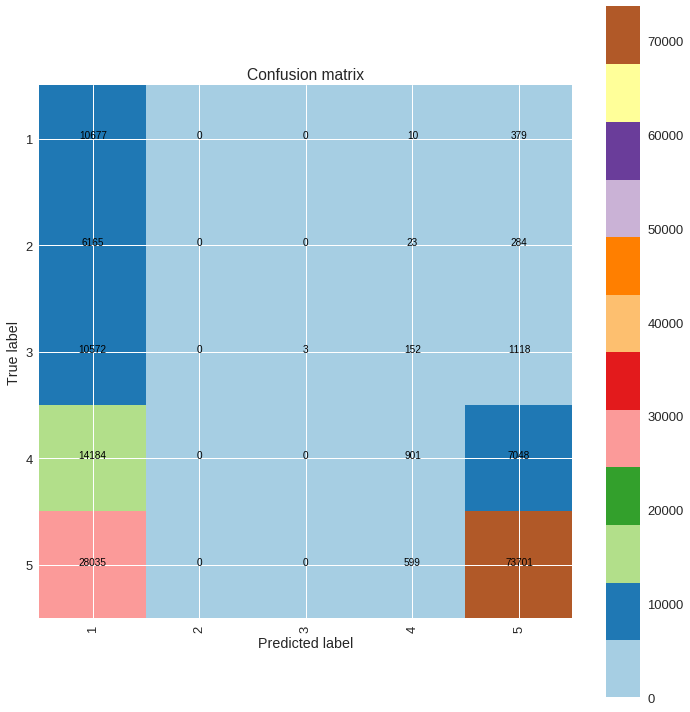

In [0]:
labels = [1,2,3,4,5]
cnf_matrix = confusion_matrix(reverse_y_test, reverse_y_pred)
print(plot_confusion_matrix(cnf_matrix, classes = labels))

Исходя из репорта видно, что:
- отзывы с оценками 2 и 3 классифицуются хуже всего.
- отзывы на 5 классифицируются достаточно неплохо, но не стоит забывать, что их больше всего и возможно сети на них легче всего выучиться (несмотря на то, что их и подрезали при помощи UnderSampling'a).
- достаточно много отзывов, классифицируемых как 1, хотя скорее всего так происходит, потому, что на этот класс приходятся, в большинстве своем, missclasified отзывы.

#### fasttext.

Обучить «fasttext» модель на n-граммах используя случайную инициализацию эмбедингов.

In [0]:
K.clear_session()

In [0]:
#read from disk
path = "drive/My Drive/data/models/task3_data_preprocessed/"
with open(path + "tmp_tokenized.pickle", "rb") as f:
    x_train,x_test,y_train,y_test = pickle.load(f)

In [0]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)

# convert integers to dummy variables (i.e. one hot encoded)
y_train = np_utils.to_categorical(encoded_y_train)
y_test = np_utils.to_categorical(encoded_y_test)

In [0]:
# Set parameters:
# ngram_range = 2 will add bi-grams features
ngram_range = 2
max_features = 25000
maxlen = 50
batch_size = 16
embedding_dims = 32
epochs = 7
task3_filepath = "drive/My Drive/data/models/subtask3/"

In [0]:
#read from disk
with open(task3_filepath + "tmp_tokenized_data.pickle", "rb") as f:
    max_features,x_train_tokenized,x_test_tokenized,y_train,y_test = pickle.load(f)

In [0]:
%%time
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)

x_train_tokenized = tokenizer.texts_to_sequences(x_train)
x_test_tokenized  = tokenizer.texts_to_sequences(x_test)

CPU times: user 1min 32s, sys: 358 ms, total: 1min 32s
Wall time: 1min 32s


In [0]:
print('Average train sequence length: {}'.format(
        np.mean(list(map(len, x_train_tokenized)), dtype=int)))
print('Average test sequence length: {}'.format(
        np.mean(list(map(len, x_test_tokenized)), dtype=int)))

Average train sequence length: 21
Average test sequence length: 21


In [0]:
def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))

In [0]:
def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

In [0]:
if ngram_range > 1:
    print('Adding {}-gram features'.format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in x_train_tokenized:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = max_features + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_features is the highest integer that could be found in the dataset.
    max_features = np.max(list(indice_token.keys())) + 1

    # Augmenting x_train_tokenized and x_test_tokenized with n-grams features
    x_train_tokenized = add_ngram(x_train_tokenized, token_indice, ngram_range)
    x_test_tokenized = add_ngram(x_test_tokenized, token_indice, ngram_range)
    
    print('Average train sequence length: {}'.format(
        np.mean(list(map(len, x_train_tokenized)), dtype=int)))
    print('Average test sequence length: {}'.format(
        np.mean(list(map(len, x_test_tokenized)), dtype=int)))

Adding 2-gram features
Average train sequence length: 41
Average test sequence length: 34


In [0]:
print('Pad sequences (samples x time)')
x_train_tokenized = sequence.pad_sequences(x_train_tokenized, padding='post', maxlen=maxlen)
x_test_tokenized = sequence.pad_sequences(x_test_tokenized, padding='post', maxlen=maxlen)
print('x_train_tokenized shape:', x_train_tokenized.shape)
print('x_test_tokenized shape:', x_test_tokenized.shape)

Pad sequences (samples x time)
x_train_tokenized shape: (615400, 50)
x_test_tokenized shape: (153851, 50)


In [0]:
#dump to disk
with open(task3_filepath + "tmp_tokenized_data.pickle", "wb") as f:
    pickle.dump((max_features, x_train_tokenized,x_test_tokenized,y_train,y_test), f)

In [0]:
#read from disk
with open(task3_filepath + "tmp_tokenized_data.pickle", "rb") as f:
    max_features,x_train_tokenized,x_test_tokenized,y_train,y_test = pickle.load(f)

In [0]:
print (x_train_tokenized.shape , x_test_tokenized.shape)

(615400, 50) (153851, 50)


In [0]:
print (max_features)

5634317


In [0]:
max_features * embedding_dims

180298144

370 262 528

185 131 264

In [0]:
'''# adam works too slow, for test use SGD
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, momentum=0.9)''';

from keras.optimizers import TFOptimizer


In [0]:
print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
# используя случайную инициализацию эмбедингов
model.add(Embedding(input_dim = max_features,
                    output_dim = embedding_dims,
                    input_length=maxlen, 	
                    embeddings_initializer = 'glorot_uniform')) 

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model.add(GlobalAveragePooling1D())

# We project onto a single unit output layer, and squash it with a softmax:
model.add(Dense(5, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              #optimizer = sgd,
              #optimizer='adam',
              optimizer=TFOptimizer(tf.train.AdamOptimizer(0.01)),
              metrics=['accuracy'])


model.summary()

Build model...
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 32)            180298144 
_________________________________________________________________
global_average_pooling1d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 180,298,309
Trainable params: 180,298,309
Non-trainable params: 0
_________________________________________________________________


In [0]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, 
                              verbose=1, min_delta=0.01,
                              mode='min',restore_best_weights=True)


checkpoint = ModelCheckpoint(task3_filepath + 'model3_undersampled.hdf5', monitor='val_loss', 
                             verbose=1, save_best_only=True, mode='min')

m_callbacks = [checkpoint, earlyStopping]

In [0]:
def ratio_multiplier(y):
  multiplier = {0: 1, 1: 1, 2: 1, 3: 0.6, 4: 0.25}
  target_stats = Counter(y)
  for key, value in target_stats.items():
    if key in multiplier:
      target_stats[key] = int(value * multiplier[key])
  return target_stats


steps_per_epoch_train = x_train_tokenized.shape[0] // batch_size
steps_per_epoch_test = x_test_tokenized.shape[0] // batch_size
print (steps_per_epoch_train, steps_per_epoch_test)

38462 9615


In [0]:
training_generator, steps_per_epoch = balanced_batch_generator(
    x_train_tokenized, y_train, 
    sampler=RandomUnderSampler(sampling_strategy = ratio_multiplier,random_state = seed), 
    batch_size=batch_size, random_state=seed)

In [0]:
from collections import OrderedDict
#multiplier = {0: 1, 1: 1, 2: 1, 3: 0.7,4: 0.4}
reverse_y_train = np.argmax(y_train, axis=1)
reverse_y_train = ratio_multiplier(reverse_y_train)

print (OrderedDict(sorted(reverse_y_train.items(), key=lambda t: t[0])))

OrderedDict([(0, 44261), (1, 25890), (2, 47381), (3, 53119), (4, 102334)])


In [0]:
print (steps_per_epoch)

17061


In [0]:
%%time
print('Train...')
history_model = model.fit_generator(epochs=epochs, verbose = 1, callbacks = m_callbacks, shuffle = True,
                                    generator = training_generator, #train_flow_genetator(x_train_tokenized, y_train,batch_size), 
                                    steps_per_epoch = steps_per_epoch, #steps_per_epoch_train, 
                                    validation_data=test_flow_genetator(x_test_tokenized, y_test, batch_size),
                                    validation_steps=steps_per_epoch_test)


'''history_model = model.fit(x_train_tokenized, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=m_callbacks,
          validation_data=(x_test_tokenized, y_test))''';

Train...
Instructions for updating:
Use tf.cast instead.
Epoch 1/7
 1439/17061 [=>............................] - ETA: 5:20:32 - loss: 1.2571 - acc: 0.4750

In [0]:
'''# serialize model to JSON
model_json = model.to_json()
with open(path + "model" + ".json", "w") as json_file:
    json_file.write(model_json)''';

with open(task3_filepath + "history3_undesample"+ ".json", 'w') as f:
    json.dump(history_model.history, f)
    
'''# serialize weights to HDF5
model.save_weights(path + "model" +  ".h5")
print("Saved model to disk")''';

In [0]:
#load history
json_file = open(task3_filepath + "history3_undesample"+ ".json", 'r')
loaded_history_json = json.load(json_file)
json_file.close()

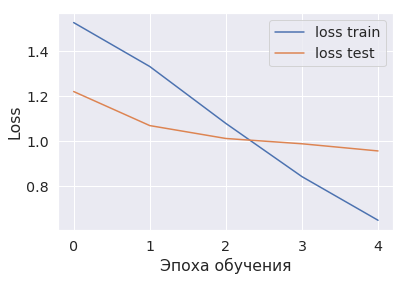

In [0]:
plt.plot(loaded_history_json['loss'], 
         label='loss train')
plt.plot(loaded_history_json['val_loss'], 
         label='loss test')
plt.xlabel('Эпоха обучения')
plt.ylabel('Loss')
plt.legend()
plt.show()

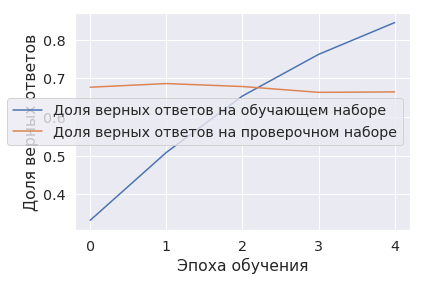

In [0]:
plt.plot(loaded_history_json['acc'], 
         label='acc train')
plt.plot(loaded_history_json['val_acc'], 
         label='acc test')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [0]:
K.clear_session()

In [0]:
loaded_model = Sequential() #?
loaded_model = load_model(task3_filepath + 'model3_undersampled.hdf5')

In [0]:
y_predicted_scores = loaded_model.predict(x_test_tokenized)
y_predicted_scores[y_predicted_scores>=0.5] = 1
y_predicted_scores[y_predicted_scores<0.5] = 0

print('Classification report\n')
print(classification_report(y_test, y_predicted_scores))

Classification report

              precision    recall  f1-score   support

           0       0.65      0.30      0.41       830
           1       1.00      0.00      0.01       485
           2       0.40      0.07      0.12       888
           3       0.39      0.10      0.16      1660
           4       0.91      0.61      0.73      7675

   micro avg       0.85      0.45      0.59     11538
   macro avg       0.67      0.22      0.29     11538
weighted avg       0.78      0.45      0.55     11538
 samples avg       0.45      0.45      0.45     11538



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [0]:
reverse_y_test = np.argmax(y_test, axis=1)
reverse_y_pred = np.argmax(y_predicted_scores, axis=1)

Confusion matrix, without normalization
None


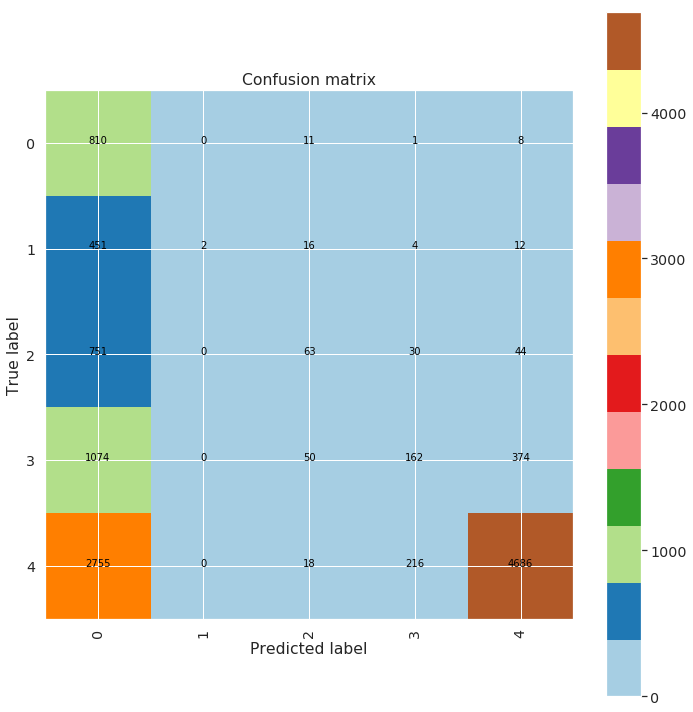

In [0]:
labels = [0,1,2,3,4]
cnf_matrix = confusion_matrix(reverse_y_test, reverse_y_pred)
print(plot_confusion_matrix(cnf_matrix, classes = labels))

В принципе, эта модель нейронной сети выглядит поинтереснее чем предыдущая, хоть у нее и f1-score будет поменьше.
В данном случае, количество выходных слоев embedding и количество max_features уменьшено в два раза (чтобы не падало с ошибкой окружение в колабе), но по результатам оказалось достаточно неплохо.

Судя по репорту, смущает больше всего precision у класса 1, при этом полнота = 0. Т.е. мы корректно предсказали 2 объекта, при этом пропустили все остальные...


#### Character based model.
Обучить сharacter based модель (вместо слов мы подаём предложение посимвольно).

In [0]:
K.clear_session()
del model, loaded_model

In [0]:
max_features = 40000
maxlen = 250
batch_size = 256
embedding_dims = 64
epochs = 5
task4_filepath = "drive/My Drive/data/models/subtask4/"

In [0]:
%%time
tokenizer = Tokenizer(
    char_level=True,
    #filters=None,
    lower=True,
    num_words=max_features
)

tokenizer.fit_on_texts(x_train)

x_train_tokenized = tokenizer.texts_to_sequences(x_train)
x_test_tokenized  = tokenizer.texts_to_sequences(x_test)

CPU times: user 7.9 s, sys: 36.9 ms, total: 7.94 s
Wall time: 7.95 s


In [0]:
print('Average train sequence length: {}'.format(
        np.mean(list(map(len, x_train_tokenized)), dtype=int)))
print('Average test sequence length: {}'.format(
        np.mean(list(map(len, x_test_tokenized)), dtype=int)))

Average train sequence length: 202
Average test sequence length: 195


In [0]:
%%time
x_train_tokenized = sequence.pad_sequences(x_train_tokenized, padding='post', maxlen=maxlen)
x_test_tokenized = sequence.pad_sequences(x_test_tokenized, padding='post', maxlen=maxlen)

CPU times: user 822 ms, sys: 49.2 ms, total: 871 ms
Wall time: 872 ms


In [0]:
x_train_tokenized.shape

(40253, 250)

In [0]:
x_test_tokenized.shape

(11538, 250)

In [0]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
print (vocab_size)

84


LTSM Shape note:
- Samples. One sequence is one sample. A batch is comprised of one or more samples.
- Time Steps. One time step is one point of observation in the sample.
- Features. One feature is one observation at a time step.

so, we have x_train_part.shape[0] samples, 1 time step and maxlen = x_train_part.shape[1] features.

In [0]:
'''x_train_part = np.reshape(x_train_part, (x_train_part.shape[0], 1,  x_train_part.shape[1]))
x_test_part = np.reshape(x_test_part, ( x_test_part.shape[0], 1,  x_test_part.shape[1]))

x_train_part.shape''';

В качестве примера имплементации была взята модель с каггла: 

https://www.kaggle.com/mamamot/character-based-lstm

и к ней добавлен входной embedding-layer.

Также для сравнения была взята bidirectional lstm из второй подзадачи.

In [0]:
# define model
model = Sequential()

model.add(Embedding(input_dim = vocab_size,
                    output_dim = embedding_dims,
                    input_length=maxlen, 
                    embeddings_initializer = 'glorot_uniform'))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(embedding_dims)))
model.add(Dropout(0.5))
model.add(Dense(5, activation="softmax"))


'''model.add(Embedding(input_dim = vocab_size,
                    output_dim = embedding_dims,
                    input_length=maxlen, 
                    embeddings_initializer = 'glorot_uniform')) 
model.add(BatchNormalization())
#model.add(LSTM(128, input_shape=(x_train_part.shape[1], x_train_part.shape[2]), activation="tanh", return_sequences=True))
model.add(LSTM(128, input_shape=(maxlen, max_features), activation="tanh", return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(LSTM(64, input_shape=(500, 25000), activation="tanh", return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(100, activation="tanh"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(50, activation="tanh"))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(5, activation="softmax"))''';#backup



earlyStopping = EarlyStopping(monitor='val_acc', patience=2, verbose=2, mode='max',restore_best_weights=True)
model.compile(loss='categorical_crossentropy',
              #optimizer = sgd,
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 64)           5376      
_________________________________________________________________
batch_normalization_1 (Batch (None, 250, 64)           256       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 72,325
Trainable params: 72,197
Non-trainable params: 128
_________________________________________________________________


In [0]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, 
                              verbose=1, min_delta=0.01,
                              mode='min',restore_best_weights=True)


checkpoint = ModelCheckpoint(task4_filepath + 'baseline_model4.hdf5', monitor='val_acc', 
                             verbose=1, save_best_only=True, mode='max')

m_callbacks = [checkpoint, earlyStopping]

In [0]:
history_model = model.fit(x_train_tokenized, y_train,
          batch_size=batch_size,
          epochs=epochs, #epochs
          verbose = 1,
          callbacks=m_callbacks,
          validation_data=(x_test_tokenized, y_test))

Train on 40253 samples, validate on 11538 samples
Epoch 1/5
40253/40253 [==============================] - 317s 8ms/step - loss: 1.5685 - acc: 0.2912 - val_loss: 1.3833 - val_acc: 0.5534

Epoch 00001: val_acc improved from -inf to 0.55339, saving model to drive/My Drive/data/models/subtask4/baseline_model4.hdf5
Epoch 2/5
40253/40253 [==============================] - 312s 8ms/step - loss: 1.5284 - acc: 0.3217 - val_loss: 1.3911 - val_acc: 0.4739

Epoch 00002: val_acc did not improve from 0.55339
Epoch 3/5
40253/40253 [==============================] - 314s 8ms/step - loss: 1.5001 - acc: 0.3389 - val_loss: 1.2727 - val_acc: 0.5656

Epoch 00003: val_acc improved from 0.55339 to 0.56561, saving model to drive/My Drive/data/models/subtask4/baseline_model4.hdf5
Epoch 4/5
40253/40253 [==============================] - 311s 8ms/step - loss: 1.4687 - acc: 0.3615 - val_loss: 1.2242 - val_acc: 0.5418

Epoch 00004: val_acc did not improve from 0.56561
Epoch 5/5
40253/40253 [======================

In [0]:
'''# serialize model to JSON
model_json = model.to_json()
with open(path + "model" + ".json", "w") as json_file:
    json_file.write(model_json)
''';
with open(task4_filepath + "history4"+ ".json", 'w') as f:
    json.dump(history_model.history, f)
'''    
# serialize weights to HDF5
model.save_weights(path + "model" +  ".h5")
print("Saved model to disk")''';

In [0]:
#load history
json_file = open(task4_filepath + "history4"+ ".json", 'r')
loaded_history_json = json.load(json_file)
json_file.close()

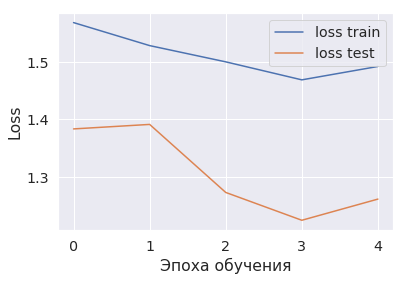

In [0]:
plt.plot(loaded_history_json['loss'], 
         label='loss train')
plt.plot(loaded_history_json['val_loss'], 
         label='loss test')
plt.xlabel('Эпоха обучения')
plt.ylabel('Loss')
plt.legend()
plt.show()

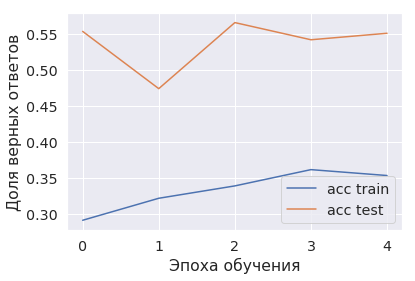

In [0]:
plt.plot(loaded_history_json['acc'], 
         label='acc train')
plt.plot(loaded_history_json['val_acc'], 
         label='acc test')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [0]:
loaded_model = Sequential() #?
loaded_model = load_model(task4_filepath + 'baseline_model4.hdf5')

In [0]:
y_predicted_scores = loaded_model.predict(x_test_tokenized)

In [0]:
y_predicted_scores[y_predicted_scores>=0.5] = 1
y_predicted_scores[y_predicted_scores<0.5] = 0

print('Classification report\n')
print(classification_report(y_test, y_predicted_scores))

Classification report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       830
           1       0.00      0.00      0.00       485
           2       0.00      0.00      0.00       888
           3       0.00      0.00      0.00      1660
           4       0.90      0.17      0.29      7675

   micro avg       0.90      0.11      0.20     11538
   macro avg       0.18      0.03      0.06     11538
weighted avg       0.60      0.11      0.19     11538
 samples avg       0.11      0.11      0.11     11538



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Для этой задачи буквенная модель не является оптимальной, т.к. входные данные - тексты отзывов, состоящие из двух алфавитов + с отсеченной пунктуацией, по сути состоят из одних и тех же символов и поэтому здесь не получается четкой классификации.

P.s. сравнение производилось на нескольких моделях (вторая - закоменнтирована, но её бекап был предварительно сделан, суть результатов схожая).

Возможно использовав иную преодбработку данных (не убирать пунктуацию, попробовать поработать с частицами), то  , за счет большего количества пунктуации, удастся улучшить обобщающую способность этой модели.

#### Conclusions.

На небольшом объеме данных лучше всего показала себя логистическая регрессия, модели lstm и "fasstext" показали результаты несколько хуже.

Исходя из результатов, если дообучить fasstext на бОльших объемах данных + изменить гиперпаратры num_features, embedding_dims, то она скорее всего покажет наилучшие результаты.

Символьная модель показала наихудший результаты, в силу того, что эта задача не является подходящей для этой структруы нейросети.

#### Word2Vec.

Обучить модель из примера имплементации, но с использованием уже предобученного word2vec для русского языка в качестве инициализации эмбединга.

Так, как mystem не работает в колабе (но работает на локальной машине) https://github.com/nlpub/pymystem3/issues/28

, то удалось придти к  следующему pipeline:

- препроцессим тексты при помощи mystem для приведения их к одному виду с преодобученным word2vec
- составляем embedding layer, используя уже предобученный word2vec
- обучаем нейросеть.

Но, на шаге 1 в колабе возникли проблемы + либа для препроцессинга достаточно медленная (1-2 секунды на текст), поэтому продолжу эксперимент с bpemb/fasttext.

https://nlp.h-its.org/bpemb/ru/



In [20]:
#path_word2vec = "drive/My Drive/data/models/word2vec/"
path_word2vec = "models/word2vec/"

In [21]:
udpipe_url = 'https://rusvectores.org/static/models/udpipe_syntagrus.model'
modelfile = wget.download(udpipe_url,path_word2vec)

100% [........................................................................] 40616122 / 40616122

In [22]:
def clean_token(token, misc):
    """
    :param token:  токен (строка)
    :param misc:  содержимое поля "MISC" в CONLLU (строка)
    :return: очищенный токен (строка)
    """
    out_token = token.strip().replace(' ', '')
    if token == 'Файл' and 'SpaceAfter=No' in misc:
        return None
    return out_token


def clean_lemma(lemma, pos):
    """
    :param lemma: лемма (строка)
    :param pos: часть речи (строка)
    :return: очищенная лемма (строка)
    """
    out_lemma = lemma.strip().replace(' ', '').replace('_', '').lower()
    if '|' in out_lemma or out_lemma.endswith('.jpg') or out_lemma.endswith('.png'):
        return None
    if pos != 'PUNCT':
        if out_lemma.startswith('«') or out_lemma.startswith('»'):
            out_lemma = ''.join(out_lemma[1:])
        if out_lemma.endswith('«') or out_lemma.endswith('»'):
            out_lemma = ''.join(out_lemma[:-1])
        if out_lemma.endswith('!') or out_lemma.endswith('?') or out_lemma.endswith(',') \
                or out_lemma.endswith('.'):
            out_lemma = ''.join(out_lemma[:-1])
    return out_lemma
  
def num_replace(word):
    newtoken = 'x' * len(word)
    return newtoken

In [23]:
def process(pipeline, text, keep_pos=True, keep_punct=False):
    entities = {'PROPN'}
    named = False
    memory = []
    mem_case = None
    mem_number = None
    tagged_propn = []

    # обрабатываем текст, получаем результат в формате conllu:
    processed = pipeline.process(text)
    #print (processed)

    # пропускаем строки со служебной информацией:
    content = [l for l in processed.split('\n') if not l.startswith('#')]

    # извлекаем из обработанного текста леммы, тэги и морфологические характеристики
    tagged = [w.split('\t') for w in content if w]

    for t in tagged:
        if len(t) != 10:
            continue
        (word_id, token, lemma, pos, xpos, feats, head, deprel, deps, misc) = t
        token = clean_token(token, misc)
        lemma = clean_lemma(lemma, pos)
        if not lemma or not token:
            continue
        if pos in entities:
            if '|' not in feats:
                tagged_propn.append('%s_%s' % (lemma, pos))
                continue
            morph = {el.split('=')[0]: el.split('=')[1] for el in feats.split('|')}
            if 'Case' not in morph or 'Number' not in morph:
                tagged_propn.append('%s_%s' % (lemma, pos))
                continue
            if not named:
                named = True
                mem_case = morph['Case']
                mem_number = morph['Number']
            if morph['Case'] == mem_case and morph['Number'] == mem_number:
                memory.append(lemma)
                if 'SpacesAfter=\\n' in misc or 'SpacesAfter=\s\\n' in misc:
                    named = False
                    past_lemma = '::'.join(memory)
                    memory = []
                    tagged_propn.append(past_lemma + '_PROPN ')
            else:
                named = False
                past_lemma = '::'.join(memory)
                memory = []
                tagged_propn.append(past_lemma + '_PROPN ')
                tagged_propn.append('%s_%s' % (lemma, pos))
        else:
            if not named:
                if pos == 'NUM' and token.isdigit():  # Заменяем числа на xxxxx той же длины
                    lemma = num_replace(token)
                tagged_propn.append('%s_%s' % (lemma, pos))
            else:
                named = False
                past_lemma = '::'.join(memory)
                memory = []
                tagged_propn.append(past_lemma + '_PROPN ')
                tagged_propn.append('%s_%s' % (lemma, pos))

    if not keep_punct:
        tagged_propn = [word for word in tagged_propn if word.split('_')[1] != 'PUNCT']
    if not keep_pos:
        tagged_propn = [word.split('_')[0] for word in tagged_propn]
    return tagged_propn

In [24]:
print('\nLoading the model...', file=sys.stderr)
model = udpipe_Model.load(path_word2vec + "udpipe_syntagrus.model")
process_pipeline = udpipe_Pipeline(model, 'tokenize', udpipe_Pipeline.DEFAULT, udpipe_Pipeline.DEFAULT, 'conllu') #udpipe_Pipeline


Loading the model...


In [26]:
prepocessed_x_data = []

In [27]:
#test preprocess
for line in tqdm(x_data):
    # line = unify_sym(line.strip()) # здесь могла бы быть ваша функция очистки текста
    output = process(process_pipeline, text=line,keep_punct = False)
    prepocessed_x_data.append(output)

In [28]:
x_data[0]

'Потрясающе красивая графика космоса! Уже за это игру можно полюбить. Так же в наличии интересный осмысленный сюжет и удобное управление.'

In [29]:
prepocessed_x_data[0]

['потрясающе_ADV',
 'красивый_ADJ',
 'график_NOUN',
 'космос_NOUN',
 'уже_ADV',
 'за_ADP',
 'этот_PRON',
 'игра_NOUN',
 'можно_ADV',
 'полюбить_VERB',
 'так_ADV',
 'же_PART',
 'в_ADP',
 'наличие_NOUN',
 'интересный_ADJ',
 'осмысленный_ADJ',
 'сюжет_NOUN',
 'и_CCONJ',
 'удобный_ADJ',
 'управление_NOUN']

In [30]:
with open(path_word2vec + "train_preprocess.pickle", "wb") as f:
    pickle.dump((prepocessed_x_data, y_data), f)

In [0]:
#prepocessed_train_texts = []
#prepocessed_test_texts = []

In [0]:
print('Processing input...', file=sys.stderr)

#i = 0
for line in tqdm(x_test):
  # line = unify_sym(line.strip()) # здесь могла бы быть ваша функция очистки текста
  output = process(process_pipeline, text=line)
  prepocessed_test_texts.append(output)
#  i+=1
#  if (i == 50000):
#    break


Processing input...


In [0]:
'''#dump to disk
with open(path_word2vec + "train_preprocess.pickle", "wb") as f:
    pickle.dump((prepocessed_train_texts, prepocessed_test_texts,x_train,x_test, y_train, y_test), f)''';

In [0]:
#read from disk
with open(path_word2vec + "train_preprocess.pickle", "rb") as f:
    prepocessed_train_texts, prepocessed_test_texts, x_train, x_test, y_train, y_test = pickle.load(f)

In [0]:
len(prepocessed_test_texts)

153851

In [0]:
prepocessed_test_texts[1]

['игра_NOUN',
 'хороший_ADJ',
 'ребенок_NOUN',
 'брать_VERB',
 'не_PART',
 'сомневаться_VERB',
 'единственный_ADJ',
 'минус_ADP',
 'отсутствие_NOUN',
 'русский_ADJ',
 'язык_NOUN',
 'субтитр_NOUN',
 'иметь_VERB',
 'ввиду_NOUN',
 'хотя_SCONJ',
 'понятный_ADJ',
 'действие_NOUN',
 'сюжет_VERB',
 'кто_PRON',
 'интересный_ADJ',
 'хотя_SCONJ',
 'данный_ADJ',
 'игра_NOUN',
 'vita_X',
 'рs3_NUM',
 'идти_VERB',
 'сабам_NOUN',
 'возможно_ADV',
 'добавить_VERB',
 'сомневаться_VERB']

In [0]:
len(prepocessed_train_texts)
#50 000
#486034 last index

615400

In [0]:
x_train[615399]

'материал верха промокаемый куртка простегана насквозь это вид не портит раннюю среднюю весну осень'

In [0]:
prepocessed_train_texts[615399]

['материал_NOUN',
 'верх_NOUN',
 'промокаемый_VERB',
 'куртка_NOUN',
 'стегать_VERB',
 'насквозь_ADV',
 'этот_PRON',
 'вид_NOUN',
 'не_PART',
 'портить_VERB',
 'ранний_ADJ',
 'средний_ADJ',
 'весна_NOUN',
 'осень_NOUN']

In [0]:
y_train[615399]

array([0., 0., 0., 0., 1.], dtype=float32)

In [0]:
gensim_model_path = path_word2vec + 'ruwikiruscorpora-nobigrams_upos_skipgram_300_5_2018.vec.gz'
gensim_model = gensim.models.KeyedVectors.load_word2vec_format(gensim_model_path, binary=False)

In [0]:
#gensim_model.most_similar('платить_VERB')
#word_vector = gensim_model['платить_VERB']
#word_vector.shape

In [0]:
#gensim_model.most_similar('платить_VERB')
#word_vector = gensim_model['платить_VERB']
#word_vector.shape
gensim_model.most_similar('материал_NOUN')

[('материаловек_NOUN', 0.7480952739715576),
 ('материалов_NOUN', 0.6279478073120117),
 ('материала_NOUN', 0.6037032604217529),
 ('материалом_NOUN', 0.5942106246948242),
 ('материал_PROPN', 0.5886454582214355),
 ('наноструктурированный_VERB', 0.5740280151367188),
 ('гидроизоляциоть_ADJ', 0.5720974206924438),
 ('трудногорючий_ADJ', 0.5703890919685364),
 ('наноструктурный_ADJ', 0.5681331157684326),
 ('биосовместимый_ADJ', 0.5679646134376526)]

In [0]:
gensim_model.similarity('женщина_NOUN', 'граната_NOUN')

0.11830321

In [0]:
gensim_model.most_similar(positive=['пицца_NOUN', 'россия_NOUN'], negative=['италия_NOUN'])[0][0]

'ассорти_NOUN'

In [0]:
max_features = 35000
maxlen = 50
#MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300



In [0]:
batch_size = 32
epochs = 5

In [0]:
%%time
tokenizer = Tokenizer(num_words=max_features,lower = False)

tokenizer.fit_on_texts(prepocessed_train_texts)

x_train_tokenized = tokenizer.texts_to_sequences(prepocessed_train_texts)
x_test_tokenized  = tokenizer.texts_to_sequences(prepocessed_test_texts)

word_index = tokenizer.word_index

CPU times: user 34.6 s, sys: 310 ms, total: 34.9 s
Wall time: 34.9 s


In [0]:
%%time
x_train_tokenized = sequence.pad_sequences(x_train_tokenized, padding='post', maxlen=maxlen)
x_test_tokenized = sequence.pad_sequences(x_test_tokenized, padding='post', maxlen=maxlen)

CPU times: user 4.2 s, sys: 22.3 ms, total: 4.22 s
Wall time: 4.23 s


In [0]:
len(word_index) + 1

341759

SVD!!!

Rework word preprocess!!!

to reduce null word embeddings. + use new gensim model from http://rusvectores.org/ru/models/

In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
i=0
for word, i in word_index.items():
  try:
    embedding_vector = gensim_model[word]
    if embedding_vector is not None:
      # words not found in embedding index will be all-zeros.
      embedding_matrix[i] = embedding_vector
  except KeyError: #for case when words not found
    i+=1
    continue
    
    
#print ("Number missing words: " + str(i))

ValueError: ignored

In [0]:
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 250576


In [0]:
embedding_matrix.shape

(341759, 300)

In [0]:
#svd to reduce sise
svd = TruncatedSVD(n_components=128, n_iter=15, random_state=seed)#,algorithm='arpack' can get better result,but time... or 3000

In [0]:
%%time
embedding_matrix_reduced = svd.fit_transform(embedding_matrix)

CPU times: user 2min 30s, sys: 11.8 s, total: 2min 42s
Wall time: 1min 42s


In [0]:
print(svd.explained_variance_ratio_.sum())

0.7576267457501389


In [0]:
print(svd.explained_variance_.sum())

0.19238124927368677


In [0]:
embedding_matrix_reduced.shape

(341759, 128)

In [0]:
EMBEDDING_DIM = 128 # now possible to reduce

In [0]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_reduced],
                            input_length=maxlen,
                            trainable=False)

In [0]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(Conv1D(300, 3, padding='valid',activation='relu',strides=2))
model.add(Conv1D(150, 3, padding='valid',activation='relu',strides=2))
model.add(Conv1D(75, 3, padding='valid',activation='relu',strides=2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(150,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(5,activation='sigmoid'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

utils.print_summary(model,line_length = 80)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
embedding_2 (Embedding)             (None, 50, 128)                 43745152    
________________________________________________________________________________
dropout_13 (Dropout)                (None, 50, 128)                 0           
________________________________________________________________________________
conv1d_22 (Conv1D)                  (None, 24, 300)                 115500      
________________________________________________________________________________
conv1d_23 (Conv1D)                  (None, 11, 150)                 135150      
________________________________________________________________________________
conv1d_24 (Conv1D)                  (None, 5, 75)                   33825       
________________________________________________________________________________
flatten_5 (Flatten)         

In [0]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, 
                              verbose=1, min_delta=0.01,
                              mode='min',restore_best_weights=True)


checkpoint = ModelCheckpoint(path_word2vec + 'baseline_model_partial.hdf5', monitor='val_loss', 
                             verbose=1, save_best_only=True, mode='min')

m_callbacks = [checkpoint, earlyStopping]

In [0]:
steps_per_epoch_train = x_train_tokenized.shape[0] // batch_size
steps_per_epoch_test = x_test_tokenized.shape[0] // batch_size
print (steps_per_epoch_train)

19231


In [0]:
%%time
print('Train...')
history_model = model.fit_generator(epochs=epochs, verbose = 1, callbacks = m_callbacks, 
                                    shuffle = False,#shuffle = True, # true for case with imblearn generator
                                    generator = train_flow_genetator(x_train_tokenized, y_train,batch_size), 
                                    steps_per_epoch = steps_per_epoch_train, 
                                    validation_data=test_flow_genetator(x_test_tokenized, y_test, batch_size),
                                    validation_steps=steps_per_epoch_test)

Train...
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
19231/19231 [==============================] - 884s 46ms/step - loss: nan - acc: 0.3696 - val_loss: nan - val_acc: 0.0719

Epoch 00001: val_loss did not improve from inf
Epoch 2/5
  789/19231 [>.............................] - ETA: 11:21 - loss: nan - acc: 0.0728

KeyboardInterrupt: ignored

In [0]:
'''# serialize model to JSON
model_json = model.to_json()
with open(path + "model" + ".json", "w") as json_file:
    json_file.write(model_json)''';

with open(path_word2vec + "history_partial_gru"+ ".json", 'w') as f:
    json.dump(history_model.history, f)
    
'''# serialize weights to HDF5
model.save_weights(path + "model" +  ".h5")
print("Saved model to disk")''';

In [0]:
#load history
json_file = open(path_word2vec + "history_partial_gru"+ ".json", 'r')
loaded_history_json = json.load(json_file)
json_file.close()

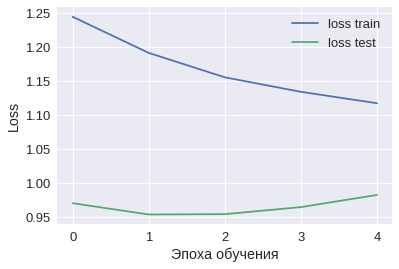

In [0]:
plt.plot(loaded_history_json['loss'], 
         label='loss train')
plt.plot(loaded_history_json['val_loss'], 
         label='loss test')
plt.xlabel('Эпоха обучения')
plt.ylabel('Loss')
plt.legend()
plt.show()

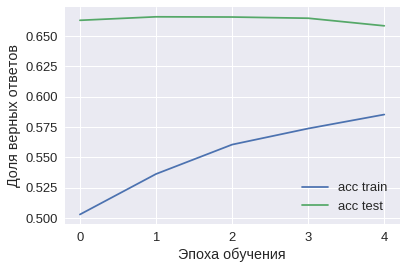

In [0]:
plt.plot(loaded_history_json['acc'], 
         label='acc train')
plt.plot(loaded_history_json['val_acc'], 
         label='acc test')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [0]:
# happy learning!
model.fit(x_train_tokenized, y_train, validation_data=(x_test_tokenized, y_test),
          epochs=2, batch_size=32)